# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install stop-words

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32916 sha256=822f8df3a18c4648133785e259b9b24fecdfe1052b52a70979f37cbd60e0e97f
  Stored in directory: /home/jovyan/.cache/pip/wheels/da/d8/66/395317506a23a9d1d7de433ad6a7d9e6e16aab48cf028a0f60
Successfully built stop-words


In [2]:
!pip install stopwords

In [3]:
!pip install imbalanced-learn

     |████████████████████████████████| 258 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 13.5 MB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 88.4 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [4]:
!pip install textblob

     |████████████████████████████████| 626 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 50.1 MB/s eta 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.6.1
    Uninstalling nltk-3.6.1:
      Successfully uninstalled nltk-3.6.1


In [5]:
!pip install catboost

In [6]:
#импорт библиотек 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
from tqdm.notebook import tqdm
import transformers
import torch
import matplotlib.font_manager as fm
from pymystem3 import Mystem
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score, recall_score
from sklearn.utils import shuffle

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords as nltk_stopwords
import time
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import make_scorer
from catboost import CatBoostClassifier, Pool
from sklearn.utils import shuffle
import spacy
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler

In [7]:
data = pd.read_csv('/datasets/toxic_comments.csv')
display(data.head())
display(data.info())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

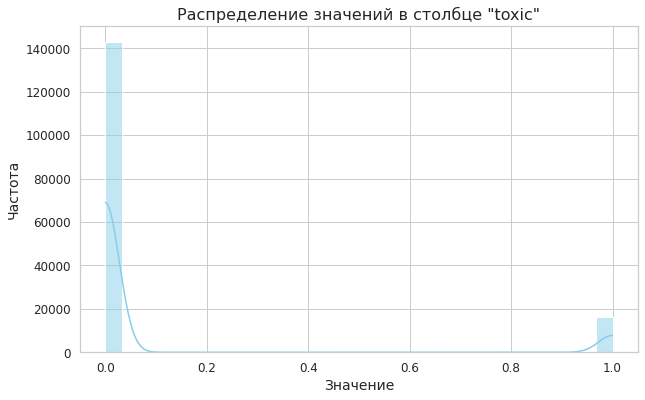

In [8]:
# Устанавливаем стиль графика
sns.set(style="whitegrid")

# Создаем гистограмму
plt.figure(figsize=(10, 6))
sns.histplot(data['toxic'], bins=30, kde=True, color='skyblue')

# Добавляем заголовок и подписи к осям
plt.title('Распределение значений в столбце "toxic"', fontsize=16)
plt.xlabel('Значение', fontsize=14)
plt.ylabel('Частота', fontsize=14)

# Улучшаем видимость меток
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Отображаем график
plt.show()

**Вывод из предварительного анализа данных**
**Общая информация о датафрейме:**

- Датафрейм содержит 159 292 объекта без пропусков.

- В датафрейме присутствуют 3 признака.

**Признаки:**

- text:
    - Содержит исходные тексты твитов.
    - Является не целевым признаком.
    - Будет использоваться в обучении и предсказании моделей.

- toxic:
    - Содержит данные по классификации текстов.
    - Является целевым признаком.
    - Состоит только из значений 0 и 1.
    - Имеет тип данных int64, что можно оптимизировать до uint8 для экономии памяти.
    - Классы не сбалансированы, с преобладанием класса 0. Этот факт необходимо учитывать при разделении датафрейма на обучающие и тестовые выборки.

- Unnamed: 0:
    - Не содержит ценной информации для обучения.
    - Не будет использоваться в дальнейшем анализе и обучении моделей.

**Рекомендуется:**
- Оптимизировать тип данных признака toxic до uint8.
- Учитывать несбалансированность классов при разделении данных на обучающую и тестовую выборки.
- Исключить признак Unnamed: 0 из дальнейшего анализа и обучения моделей.

In [9]:
# С использованием spacy
nlp = spacy.load('en_core_web_sm')

In [10]:
def clean_text_spacy(text):
    clean = nlp(" ".join(re.sub(r'[^a-zA-z]', ' ', text).split()))
    lemmatized_output = ' '.join([w.lemma_ for w in clean])
    return lemmatized_output

In [11]:
data['lemmatize'] = data['text'].apply(clean_text_spacy)

In [12]:
# Стоп-слово
stopwords = list(nltk_stopwords.words('english'))

In [13]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

## Обучение

In [14]:
# Разделение данных на обучающую, валидационную и тестовую выборки
start_time = time.time()
X_train, X_temp, y_train, y_temp = train_test_split(data['lemmatize'], data['toxic'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Data splitting time: {time.time() - start_time:.2f} seconds")

Data splitting time: 0.03 seconds


In [15]:
# Применение downsampling к обучающей выборке
rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
X_train_downsampled, y_train_downsampled = rus.fit_resample(X_train.values.reshape(-1, 1), y_train)
X_train_downsampled = X_train_downsampled.flatten()

In [16]:
# Инициализация TfidfVectorizer с использованием стоп-слов
tfidf = TfidfVectorizer(stop_words=stopwords)

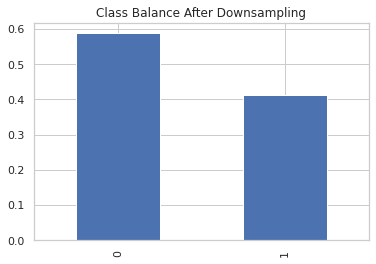

In [17]:
# Проверка баланса классов после downsampling
class_counts = y_train_downsampled.value_counts(normalize=True)
class_counts.plot(kind='bar', grid=True)
plt.title('Class Balance After Downsampling')
plt.show()

In [18]:
# Векторизация текста на уменьшенной обучающей выборке (после downsampling)
tf_idf_train_downsampled = tfidf.fit_transform(X_train_downsampled)
tf_idf_val = tfidf.transform(X_val)
tf_idf_test = tfidf.transform(X_test)

In [19]:
# Вывод размеров векторизованных данных
print(f"Shape of tf_idf_train_downsampled: {tf_idf_train_downsampled.shape}")
print(f"Shape of tf_idf_val: {tf_idf_val.shape}")
print(f"Shape of tf_idf_test: {tf_idf_test.shape}")

Shape of tf_idf_train_downsampled: (27547, 51225)
Shape of tf_idf_val: (23894, 51225)
Shape of tf_idf_test: (23894, 51225)


In [20]:
# Векторизация текста на уменьшенной обучающей выборке
tf_idf_train_downsampled = tfidf.transform(X_train_downsampled)

In [21]:
# Обучение логистической регрессии с фиксированными гиперпараметрами
start_time = time.time()
lr = LogisticRegression(C=1.0, solver='liblinear', max_iter=100, random_state=42)
lr.fit(tf_idf_train_downsampled, y_train_downsampled)
print(f"Logistic Regression training time: {time.time() - start_time:.2f} seconds")

# Оценка модели на валидационной выборке
y_val_pred_lr = lr.predict(tf_idf_val)
f1_val_lr = f1_score(y_val, y_val_pred_lr)
print(f'F1 Score (Logistic Regression, Validation): {f1_val_lr}')

Logistic Regression training time: 1.54 seconds
F1 Score (Logistic Regression, Validation): 0.7201919527500923


**Убрал поиск гиперпараметров для моделей CatBoost, XGBoost и RandomForestClassifier. Для каждой подбор шел около 5-ти часов, нецелесообразно в рамках учебного проекта**

In [22]:
# Обучение CatBoost
start_time = time.time()
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(tf_idf_train_downsampled, y_train_downsampled)
print(f"CatBoost training time: {time.time() - start_time:.2f} seconds")

# Предсказание на валидационной выборке
y_val_pred_catboost = catboost_model.predict(tf_idf_val)
f1_val_catboost = f1_score(y_val, y_val_pred_catboost)
print(f'F1 Score (CatBoost, Validation): {f1_val_catboost}')


CatBoost training time: 554.85 seconds
F1 Score (CatBoost, Validation): 0.7562858839833696


In [23]:
# Обучение XGBoost
start_time = time.time()
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(tf_idf_train_downsampled, y_train_downsampled)
print(f"XGBoost training time: {time.time() - start_time:.2f} seconds")

# Предсказание на валидационной выборке
y_val_pred_xgb = xgb_model.predict(tf_idf_val)
f1_val_xgb = f1_score(y_val, y_val_pred_xgb)
print(f'F1 Score (XGBoost, Validation): {f1_val_xgb}')

XGBoost training time: 43.26 seconds
F1 Score (XGBoost, Validation): 0.7352823388065679


In [24]:
# Обучение случайного леса
start_time = time.time()
rf = RandomForestClassifier(random_state=42)
rf.fit(tf_idf_train_downsampled, y_train_downsampled)
print(f"Random Forest training time: {time.time() - start_time:.2f} seconds")

# Предсказание на валидационной выборке
y_val_pred_rf = rf.predict(tf_idf_val)
f1_val_rf = f1_score(y_val, y_val_pred_rf)
print(f'F1 Score (Random Forest, Validation): {f1_val_rf}')

Random Forest training time: 68.26 seconds
F1 Score (Random Forest, Validation): 0.6675243521411506


**Выводы:**

- CatBoost показала наилучший результат на валидационной выборке с F1 Score 0.75. 
- Логистическая регрессия и XGBoost показали близкие результаты, немного уступая логистической регрессии. Это говорит о том, что они также являются хорошими кандидатами для данной задачи, но требуют более тщательной настройки.
- Случайный лес показал самый низкий результат среди всех моделей. Это может быть связано с недостаточной настройкой гиперпараметров или с тем, что данные не подходят для случайного леса.

## Выводы

In [25]:
y_test_pred_catboost = catboost_model.predict(tf_idf_test)
f1_test_catboost = f1_score(y_test, y_test_pred_catboost)
print(f'F1 Score (CatBoost, Test): {f1_test_catboost}')

F1 Score (CatBoost, Test): 0.7580392156862745


**Вывод по проекту:**

**Загрузка и подготовка данных:**

- Данные были загружены из файла toxic_comments.csv.
- Было выполнено разделение данных на обучающую, валидационную и тестовую выборки с использованием метода train_test_split.
- Для устранения дисбаланса классов в обучающей выборке был применен метод downsampling.
- Текстовые данные были векторизованы с использованием TfidfVectorizer, который учитывал стоп-слова.

**Обучение разных моделей:**

- Были обучены четыре модели: логистическая регрессия, случайный лес, XGBoost и CatBoost.
- Для каждой модели были использованы параметры по умолчанию, без подбора гиперпараметров (за исключением логистической регрессии).
- Лучшая модель была протестирована на тестовой выборке с использованием метрики F1 Score.

**Итог**
- CatBoost является наиболее предпочтительной моделью для данной задачи, но другие модели также заслуживают внимания при более детальной настройке. 